In [ ]:
Prediciton of Passenger Survival from titanin dataset available in kaggle.com.
The following processes
are done for solving the house price prediction problem.
1. Data is preprocessed by following steps-
    - 2.0 Correlation Analysis
    - 2.1 Outlier handling
    - 2.2 Missing value Handling
    - 2.3 Catagorical to numerical conversion
    - 2.4 Unskewing while needed 
    - 2.5 Data scaling.
2. Each preprocessing step's effectiveness is checked by simple linear regression
as ANN takes long time to train.
3. Hyperparameter was tuned by manual experiments. Comparative graph plots of each of these
experiments are shown below at hyperparameter tuning section.
4. Hyperparameter was tuned by decisions were taken with 
sk-learns gird search, code for grid search is added in grid search section.

Following algorithms were tried for grid search-

     -4.1 GradientBoostingClassifier
     -4.2 LogisticRegression
     -4.3 KNeighborsClassifier
     -4.4 GaussianNB
     -4.6 DecisionTreeClassifier
     -4.7 RandomForestClassifier
     -4.8 ExtraTreesClassifier
     -4.9 AdaBoostClassifier
     -4.10 GradientBoostingClassifier
    
5. Grid-Search with 10-Fold cross validation was done for compairing results
6. Model was trained with the tuned hyperparameters and results were submitted at
kaggle.com. Screenshots of results is shown at the end of the report at results section.

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
seed=123
np.random.seed(seed)

### Reading the Data Files

In [2]:
#train = pd.read_csv('../input/train.csv')
#test = pd.read_csv('../input/test.csv')
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Missing Data Handling

Some of the parts were inspired from -https://www.kaggle.com/tukichen/prediction-with-ensembling-method

In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
#for dataset in full_data:
#     dataset['Name_length']=pd.qcut(dataset['Name_length'],10,labels=range(10))
#     dataset['Name_length']=dataset['Name_length'].astype(int)
# Feature engineering steps ta
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
#train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

#for dataset in full_data:
       #dataset['Age'][np.isnan(dataset['Age'])]=dataset.Age.mean()
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
_,fare_bins=pd.qcut(train['Fare'],4,labels=range(0,4),retbins=True)
fare_bins=np.around(fare_bins,2)
_,age_bins=pd.cut(train['Age'],5,labels=range(0,5),retbins=True)
age_bins=np.around(age_bins,2)
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    temp=deepcopy(dataset['Fare'])

    for i in range(len(fare_bins)-1):
        ind=(temp>fare_bins[i]) & (temp<=fare_bins[i+1])
        dataset['Fare'].loc[ind]=i
    #ind=dataset['Fare']>=fare_bins[i+1]
    #dataset['Fare'].loc[ind]=i
    dataset['Fare'] = dataset['Fare'].astype(int)

    
    
    temp=deepcopy(dataset['Age'])
    #ind=temp<=age_bins[0]
    #dataset['Age'].loc[ind]=0
    for i in range(len(age_bins)-1):
        ind=temp>age_bins[i]
        ind&=temp<=age_bins[i+1] 
        dataset['Age'].loc[ind]=i
    ind=dataset['Age']>age_bins[i+1]
    dataset['Age'].loc[ind]=i
    dataset['Age']=dataset.Age.astype(int)

### Dropping useless features

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
#train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

### Plotting Feature relationship with target

Pclass


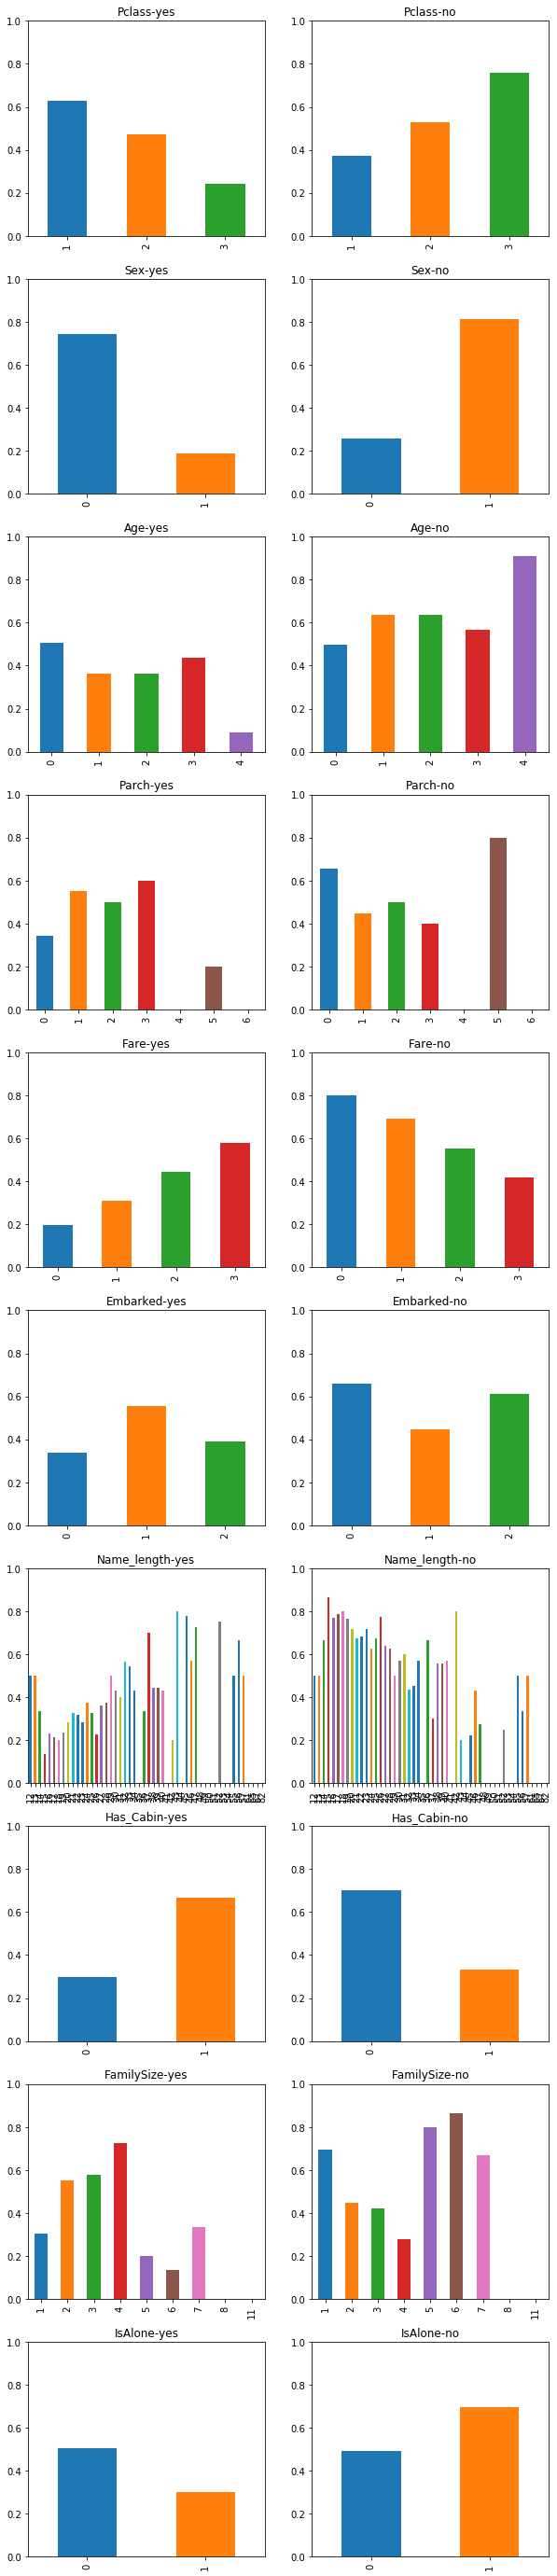

In [5]:
fig,axes=plt.subplots(nrows=10,ncols=2,figsize=(10,50))
feats=train.columns.values.tolist()[1:]
print(feats[0])
yes=list(train['Survived']==1)
no=list(train['Survived']==0)
#axes[0,0].bar(np.arange(len(yes)),train[feats[0]][yes].value_counts())
#axes[0,1].bar(np.arange(len(no)),train[feats[0]][no].value_counts())
#1train[feats[0]][yes].value_counts()
#train.plot.bar()
#plt.show()
N=len(train)
Nyes=len(yes)
Nno=len(no)
for i in range(10):
    #print(feats[i])
    ydf=train[feats[i]][yes].value_counts().sort_index()
    ndf=train[feats[i]][no].value_counts().sort_index()
    _ydf = ydf/(ydf+ndf)
    _ndf = ndf/(ydf+ndf)
    #axes[i,0].set_ylim(0,1.0)
    _ydf.plot.bar(ax=axes[i,0]).set_title(feats[i]+'-yes');axes[i,0].set_ylim(0,1.0)
    _ndf.plot.bar(ax=axes[i,1]).set_title(feats[i]+'-no');axes[i,1].set_ylim(0,1.0)
plt.show()

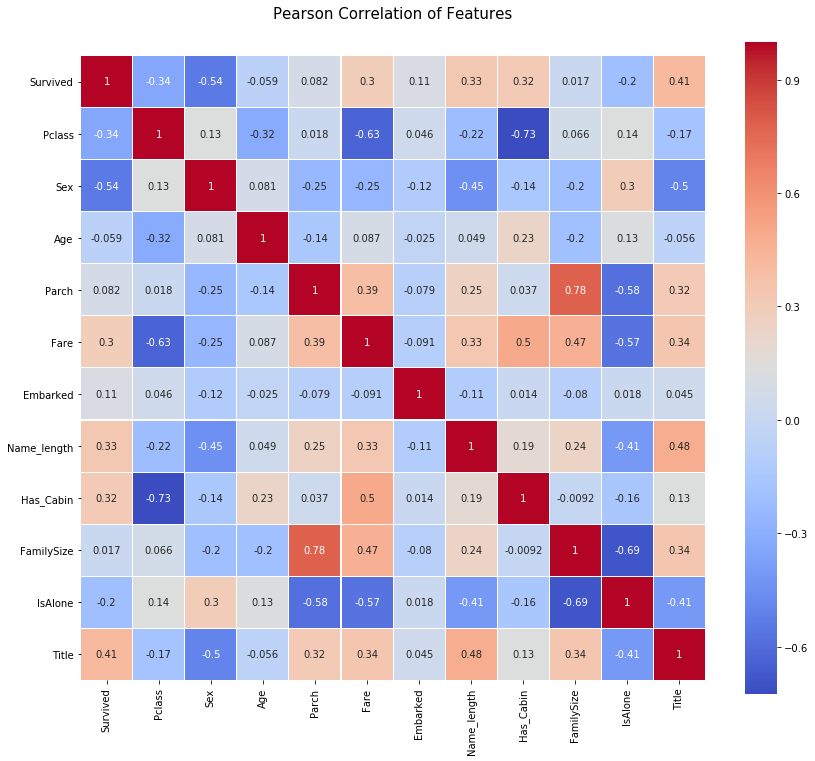

In [6]:
colormap = 'coolwarm'#plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [7]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)
kf = kf.split(train)
class sk_model(object):
    def __init__(self, clf, seed=0, params=None):
        #params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    

In [8]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'random_state' : SEED
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}

et_params_gs = {
    #'n_jobs': -1,
    'n_estimators' : [500],
    #'max_features': 0.5,

    'max_depth': [8],
    'min_samples_leaf': [2],
    #'verbose': 0,
    'random_state' : SEED
}


# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75,
    'random_state' : SEED
}

ada_params_gs = {
    'n_estimators': [100],
    'learning_rate' : [0.8,0.9,1.0],
    'random_state' : [SEED]
}


# Gradient Boosting parameters
gb_params = {
    'n_estimators': 100,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}

gb_params_gs = {
    'n_estimators': [100],
     #'max_features': 0.2,
    'max_depth': [5],
    'min_samples_leaf': [2],
    #'verbose': 0,
    'random_state' : [SEED]
}


# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025,
    'random_state' : SEED
}
svc_params_gs = {
    'kernel' : ['linear'],
    'C' : [0.025],
    'random_state' : SEED
}
xgb_params={
 'n_estimators': 1000,
 'max_depth': 2,
 'min_child_weight' : 2,
 #'gamma' : 1,
 'gamma': 1.0,                        
 'subsample': 0.8,
 'colsample_bytree' : 0.8,
 'objective' : 'binary:logistic',
 'nthread' : -1,
 'scale_pos_weight' : 1,
 'random_state' : SEED
}

xgb_params_gs={
 #learning_rate = 0.02,
 'n_estimators' : [1000],
 'max_depth' : [2],
 'min_child_weight' : [2],
 #gamma=1,
 'gamma' : [0.8,0.9,1.0],                        
 #'subsample' : [0.8],
 #'colsample_bytree' : [0.8],
 #'objective' : ['binary:logistic'],
 #'nthread' : [-1],
 #'scale_pos_weight' : [1],
 #'random_state' : [SEED]
 'random_state' : SEED
}


nb_params={
    #'random_state' : SEED
}
lr_params={
    'random_state' : SEED
}
gnb_params={
    'random_state' : SEED
}
dt_params={
    'random_state' : SEED
}
knn_params={
    'n_neighbors' : 3 ,
    #'random_state' : SEED
}

In [10]:
gbm = xgb.XGBClassifier(**xgb_params)#.fit(en_x_train, y_train)
#predictions = gbm.predict(x_test)
#for tr_ind,te_ind in kf:
#    print(len(tr_ind),len(te_ind))
#gbm = sk_model(clf=gbm, seed=SEED, params=rf_params)
#LogisticRegression
#KNeighborsClassifier
#GaussianNB
#DecisionTreeClassifier

print(knn_params)
lr = sk_model(clf=LogisticRegression, seed=SEED, params=lr_params)
knn = sk_model(clf=KNeighborsClassifier, seed=SEED, params=knn_params)
gnb = sk_model(clf=GaussianNB, seed=SEED, params=nb_params)
dt = sk_model(clf=DecisionTreeClassifier, seed=SEED, params=dt_params)
rf = sk_model(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = sk_model(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = sk_model(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = sk_model(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc =gbm# sk_model(clf=SVC, seed=SEED, params=svc_params)

{'n_neighbors': 3}


In [11]:
#train.Name_length=(train.Name_length-12)/70.0
#test.Name_length=(test.Name_length-12)/70.0
#minAge=np.min(train.Age)
#maxAge=np.max(train.Age)
#train.Age=(train.Age-minAge)/(maxAge-minAge)

In [12]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
#train=pd.get_dummies(train)
#test=pd.get_dummies(test)
cols=train.columns.values.tolist()[1:]
del cols[cols.index('Name_length')]
#del cols[cols.index('FamilySize')]
#del cols[cols.index('Embarked')]
del cols[cols.index('Parch')]
del cols[cols.index('Age')]
#del cols[cols.index('Pclass')]
#del cols[cols.index('Fare')]

#del cols[cols.index('Fare')]
#del cols[cols.index('FamilySize')]
train=pd.get_dummies(train,columns=cols)
test=pd.get_dummies(test,columns=cols)
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [13]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
#gbm=LogisticRegression(**lr_params)
#gbm=KNeighborsClassifier(**knn_params)
#gbm=GaussianNB(**nb_params)
#gbm=DecisionTreeClassifier(**dt_params)

#gbm=GradientBoostingClassifier(**gb_params)
#gbm=RandomForestClassifier(**rf_params)
#gbm=ExtraTreesClassifier(**et_params)
#gbm=AdaBoostClassifier(**ada_params)
gbm=xgb.XGBClassifier(**xgb_params)
gbm.fit(x_train,y_train)
#res=regr.predict(np.array(_test.values))

score1=cross_val_score(gbm, x_train, (y_train), scoring="accuracy",cv = 10)
#score2=cross_val_score(gb, x_train, y_train, scoring="r2",cv = 10)
msle=np.abs(score1.mean())
rmsle=np.sqrt(msle)
#r2_corr=score2.mean()
print('accuracy',msle)
#print('Mean RMSLE',np.sqrt(msle))
#print('Mean R2 Correlation',score2.mean())
#[msle,rmsle,r2_corr]
#xgb -accuracy 0.8171626376120757 #accuracy 0.82387924185677 accuracy 0.8306460674157303
#gbm -accuracy 0.8059258313471798
#rf accuracy 0.8170868800363182
#et accuracy 0.8193590398365679
#ada accuracy 0.8136655884689592
#svc accuracy 0.7866981613891727
#accuracy 0.8306460674157303

accuracy 0.8306460674157303


In [14]:
# from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
#pipe = Pipeline([
#  ('clf', xgb.XGBClassifier())
#])
clf = GridSearchCV(gbm, gb_params_gs)
clf.fit(x_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=1.0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=2, missing=None, n_estimators=1000, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100], 'max_depth': [5], 'min_samples_leaf': [2], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
sorted(clf.cv_results_.keys())
#clf.cv_results_['rank_test_score']
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_samples_leaf,param_n_estimators,param_random_state,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.107887,0.001477,0.81257,0.892256,5,2,100,0,"{'max_depth': 5, 'min_samples_leaf': 2, 'n_est...",1,0.784512,0.893939,0.828283,0.895623,0.824916,0.887205,0.004366,0.000004,0.019888,0.003637


In [16]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [18]:


et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print(np.sum(x_train),np.sum(y_train))
lr_oof_train, lr_oof_test = get_oof(lr, x_train, y_train, x_test) # Extra Trees
#print(np.sum(x_train),np.sum(y_train))
#knn_oof_train, knn_oof_test = get_oof(knn,x_train, y_train, x_test) # Random Forest
#print(np.sum(x_train),np.sum(y_train))
#gnb_oof_train, gnb_oof_test = get_oof(gnb, x_train, y_train, x_test) # AdaBoost 
#print(np.sum(x_train),np.sum(y_train))
#dt_oof_train, dt_oof_test = get_oof(dt,x_train, y_train, x_test) # Gradient Boost
#print(np.sum(x_train),np.sum(y_train))

32686 342


In [19]:
np.sum(et_oof_train)

293.0

In [20]:
en_x_train = np.concatenate(( 
    et_oof_train, 
    rf_oof_train, 
    ada_oof_train, 
    gb_oof_train, 
    svc_oof_train,
    lr_oof_train
    #knn_oof_train,
    #gnb_oof_train,
    #dt_oof_train
    ), axis=1)
en_x_test = np.concatenate(( et_oof_test, 
                            rf_oof_test, 
                            ada_oof_test, 
                            gb_oof_test, 
                            svc_oof_test,
                            lr_oof_test
                            #knn_oof_test, 
                            #gnb_oof_test, 
                            #dt_oof_test
                           ), axis=1)

In [21]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1,
 random_state=SEED).fit(en_x_train, y_train)


In [22]:
#result=gb.predict(x_test)
result = gbm.predict(en_x_test)
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': result })
StackingSubmission.to_csv("ens_all_1_21.csv", index=False)

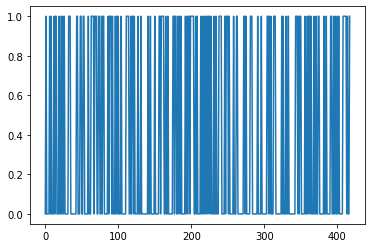

In [23]:
plt.plot(result)

In [26]:
import tensorflow
#model = tensorflow.keras.models.Sequential()
#model = tensorflow.keras.models.Model
#model.add(tensorflow.keras.layers.Dense(16, activation='relu', input_shape=(37,)))
#model.add(tensorflow.keras.layers.Dense(16, activation='relu'))
#model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))
Model = tensorflow.keras.models.Model
x= tensorflow.keras.layers.Input(shape=(37,))
y=tensorflow.keras.layers.Dense(16, activation='relu')(x)
y=tensorflow.keras.layers.Dense(16, activation='relu')(y)
y=tensorflow.keras.layers.Dense(1, activation='sigmoid')(y)
model=Model(x,y)

In [28]:
opt=tensorflow.keras.optimizers.RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [29]:
history=model.fit(x_train,y_train,epochs=500,batch_size=20,validation_split=0.20)

Train on 712 samples, validate on 179 samples
Epoch 1/500
712/712 [==============================]712/712 [==============================] - 0s 284us/step - loss: 0.5903 - acc: 0.6559 - val_loss: 0.5266 - val_acc: 0.7821

Epoch 2/500
712/712 [==============================]712/712 [==============================] - 0s 78us/step - loss: 0.5373 - acc: 0.7472 - val_loss: 0.4842 - val_acc: 0.8045

Epoch 3/500
712/712 [==============================]712/712 [==============================] - 0s 71us/step - loss: 0.5040 - acc: 0.7809 - val_loss: 0.4531 - val_acc: 0.7989

Epoch 4/500
712/712 [==============================]712/712 [==============================] - 0s 73us/step - loss: 0.4797 - acc: 0.7935 - val_loss: 0.4286 - val_acc: 0.8045

Epoch 5/500
712/712 [==============================]712/712 [==============================] - 0s 66us/step - loss: 0.4646 - acc: 0.8048 - val_loss: 0.4171 - val_acc: 0.7989

Epoch 6/500
712/712 [==============================]712/712 [=================

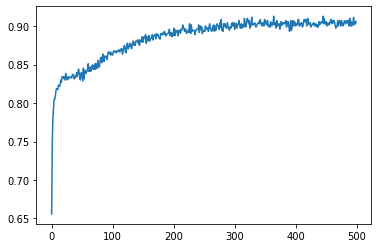

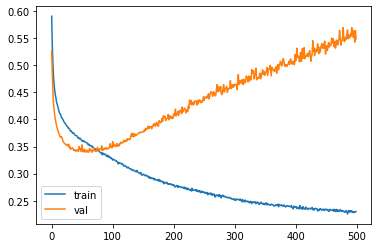

In [30]:
acc=history.history['acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(acc)
plt.show()
plt.plot(loss)
#plt.show()
plt.plot(val_loss)
plt.legend(['train','val'])
plt.show()

# history.history['loss']

In [49]:
res=model.predict(x_test)

In [50]:
res=res.reshape(-1)

In [51]:
res[res<0.5]=0
res[res>0.5]=1

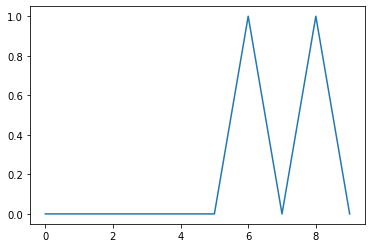

In [52]:
plt.plot(res[:10])
plt.show()

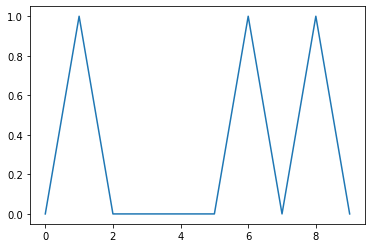

In [53]:
plt.plot(result[:10])
plt.show()

In [54]:
int(res)

TypeError: only size-1 arrays can be converted to Python scalars

In [55]:
svc.fit(x_train,y_train)
result=svc.predict(x_test)
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': np.array(res,dtype=np.int) })
StackingSubmission.to_csv("ann.csv", index=False)